In [20]:
import os
import io 
import sys
import pandas as pd
from itertools import permutations
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import pickle
import matplotlib.pyplot as plt
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier

# Get the full path to the script directory
script_dir = os.path.abspath("../scripts")

# Append the directory to the Python path
import sys
sys.path.append(script_dir)

# Now you can import the function from the file
from data_preprocessing import data_preprocessing
from feature_eng_hyp_device_activity import generateDeviceActivityFeatures
from feature_eng_account_kmeans import get_account_related_and_kmeans_feature as generateKmeansFeatures
from feature_eng_hyp_distinct_email_same_DOB import bin_distinct_emails_same_DOB as generateEmailsDobBins
from feature_eng_hyp_name_email_similarity import bin_name_email_similarity as generateNameEmailSimilarityBins
from feature_eng_hyp_session_length import bin_session_length as generateSessionLengthBins

In [40]:
import pickle

# Load the saved model
with open('../models/kmeans_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Repickle the model using the latest version of scikit-learn
with open('../models/kmeans_model.pkl', 'wb') as file:
    pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)


EOFError: Ran out of input

X = ..data/processedX_train.csv 
Y = ..data/processedy_train.csv
df = x and y 

for each of these 5 features, 
generateDeviceActivityFeatures 
generateKmeansFeatures
generateEmailsDobBins
generateNameEmailSimilarityBins
generateSessionLengthBins
perform the following- 
1. run 5! permutations and combinations of all the different ways that the data can be modified with these features engineered 
2. For each permutation, standardise a name format to easily understand which features are being engineered in that run
3. For each permutation, perform 2 operations - RFE and Lasso Regression
4. For each permutation and each operation, perform Gradient Boosting with kfold 
5. for each gradient boositng, save the model as a pkl file in ../models as a pkl file. 

iterate through all teh mdoels in the folder ../models/ and 
print all the roc-auc on a graph and show the respective names and auc score for each model



In [30]:
data_preprocessing()


Data Preprocessing...
Data Preprocessing completed successfully. Data saved to 'data/processed/undersampled_data.csv'.
Splitting the dataset into train-test subset...
Train-test split completed successfully. Data saved to 'data/processed/X_train.csv', 'data/processed/X_test.csv', 'data/processed/y_train.csv', and 'data/processed/y_test.csv'.


In [15]:
# Load X_train and y_train data from the processed CSV files
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')


string_columns = X_train.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in string_columns:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.fit_transform(X_test[col])
    print(col)



payment_type
employment_status
housing_status
source
device_os


In [13]:

# #Standardising Variables
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# #RFE
# rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
# X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
# X_test_rfe = rfe.transform(X_test_scaled)

In [16]:
# Combine X_train and y_train into a single DataFrame
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1) 

In [17]:
# Define all possible feature engineering methods
feature_engineering_methods = [
    generateDeviceActivityFeatures,
    generateKmeansFeatures,
    generateEmailsDobBins,
    generateNameEmailSimilarityBins,
    generateSessionLengthBins
]

# Generate all combinations of feature engineering methods
combinations_list = []
for r in range(1, len(feature_engineering_methods) + 1):
    combinations_list.extend(combinations(feature_engineering_methods, r))

# Assign a name to each combination for easy identification
combinations_names = ['_'.join([func.__name__ for func in comb]) for comb in combinations_list]
print(len(combinations_names))


31


In [28]:
models = []

for perm, perm_name in zip(combinations_list, combinations_names):
    df = df_train.copy()
    
    # Apply feature engineering functions
    for func in perm:
        func(df)
    
    # Separate X_train and y_train
    X_train = df.drop(columns=['fraud_bool'])
    y_train = df['fraud_bool']
    
    # Perform Lasso Regression
    lasso = LassoCV(cv=5)
    lasso.fit(X_train, y_train)
    
    # Perform feature selection based on Lasso regularization
    mask = lasso.coef_ != 0
    X_train_lasso = X_train.loc[:, mask]

    # Train Gradient Boosting model with k-fold cross-validation
    gb_model = GradientBoostingClassifier()
    scores = cross_val_score(gb_model, X_train_lasso, y_train, cv=5, scoring='roc_auc')
    
    # Print mean ROC AUC score
    print(f'{perm_name}: Mean ROC AUC - {scores.mean()}')
    print(df.columns)
    
    # Save the trained model
    model_path = f'../models/{perm_name}_gb_model.pkl'
    with open(model_path, 'wb') as file:
        pickle.dump(gb_model, file)
    
    models.append((perm_name, scores.mean()))


Feature 1 created.
Feature 1 created.
Feature 3 created.
Feature 4 created.
Feature 5 created.
Features for Device Activity Hypothesis generated.


/Users/waseemkhan/Documents/GitHub/Detect-Fraudulent-Bank-Accounts/scripts/feature_eng_hyp_device_activity.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group01['FE_02'] = "A"; group02['FE_02'] = "B"; group03['FE_02'] = "C"; group04['FE_02'] = "D"; group05['FE_02'] = "E"; group06['FE_02'] = "F"
/Users/waseemkhan/Documents/GitHub/Detect-Fraudulent-Bank-Accounts/scripts/feature_eng_hyp_device_activity.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group01['FE_02'] = "A"; group02['FE_02'] = "B"; g

KeyboardInterrupt: 

In [29]:
from sklearn.linear_model import LarsCV

models = []

for perm, perm_name in zip(combinations_list, combinations_names):
    df = df_train.copy()
    
    # Apply feature engineering functions
    for func in perm:
        func(df)
    
    # Separate X_train and y_train
    X_train = df.drop(columns=['fraud_bool'])
    y_train = df['fraud_bool']
    
    # Perform LARS Regression
    lars = LarsCV(cv=5)
    lars.fit(X_train, y_train)
    
    # Perform feature selection based on LARS
    mask = lars.coef_ != 0
    X_train_lars = X_train.loc[:, mask]

    # Train Gradient Boosting model with k-fold cross-validation
    gb_model = GradientBoostingClassifier()
    scores = cross_val_score(gb_model, X_train_lars, y_train, cv=5, scoring='roc_auc')
    
    # Print mean ROC AUC score
    print(f'{perm_name}: Mean ROC AUC - {scores.mean()}')
    print(df.columns)
    
    # Save the trained model
    model_path = f'../models/{perm_name}_gb_model.pkl'
    with open(model_path, 'wb') as file:
        pickle.dump(gb_model, file)
    
    models.append((perm_name, scores.mean()))


Feature 1 created.
Feature 1 created.
Feature 3 created.
Feature 4 created.
Feature 5 created.
Features for Device Activity Hypothesis generated.


/Users/waseemkhan/Documents/GitHub/Detect-Fraudulent-Bank-Accounts/scripts/feature_eng_hyp_device_activity.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group01['FE_02'] = "A"; group02['FE_02'] = "B"; group03['FE_02'] = "C"; group04['FE_02'] = "D"; group05['FE_02'] = "E"; group06['FE_02'] = "F"
/Users/waseemkhan/Documents/GitHub/Detect-Fraudulent-Bank-Accounts/scripts/feature_eng_hyp_device_activity.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group01['FE_02'] = "A"; group02['FE_02'] = "B"; g

KeyboardInterrupt: 

In [37]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LarsCV

models = []

# Define the undersampling ratio
undersampling_ratio = 0.5  # Adjust as needed

for perm, perm_name in zip([feature_engineering_methods], ['All functions']):
    df = df_train.copy()
    
    # Apply feature engineering functions
    for func in perm:
        func(df)
    
    # Separate X_train and y_train
    X_train = df.drop(columns=['fraud_bool'])
    y_train = df['fraud_bool']
    
    # Perform undersampling
    sampler = RandomUnderSampler(sampling_strategy=undersampling_ratio)
    X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)
    print(len(y_train_sampled))
    # Perform LARS Regression on the sampled data
    lars = LarsCV(cv=5)
    lars.fit(X_train_sampled, y_train_sampled)
    
    # Select features based on LARS coefficients
    mask = lars.coef_ != 0
    X_train_lars = X_train_sampled.loc[:, mask]

    # Train Gradient Boosting model with k-fold cross-validation
    gb_model = GradientBoostingClassifier()
    scores = cross_val_score(gb_model, X_train_lars, y_train_sampled, cv=5, scoring='roc_auc')
    
    # Print mean ROC AUC score
    print(f'{perm_name}: Mean ROC AUC - {scores.mean()}')
    print(df.columns)
    
    # Save the trained model
    model_path = f'../models/{perm_name}_gb_model.pkl'
    with open(model_path, 'wb') as file:
        pickle.dump(gb_model, file)
    
    models.append((perm_name, scores.mean()))


Feature 1 created.
Feature 1 created.
Feature 3 created.
Feature 4 created.
Feature 5 created.
Features for Device Activity Hypothesis generated.


/Users/waseemkhan/Documents/GitHub/Detect-Fraudulent-Bank-Accounts/scripts/feature_eng_hyp_device_activity.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group01['FE_02'] = "A"; group02['FE_02'] = "B"; group03['FE_02'] = "C"; group04['FE_02'] = "D"; group05['FE_02'] = "E"; group06['FE_02'] = "F"
/Users/waseemkhan/Documents/GitHub/Detect-Fraudulent-Bank-Accounts/scripts/feature_eng_hyp_device_activity.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group01['FE_02'] = "A"; group02['FE_02'] = "B"; g

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- device_os_0
- device_os_1
- device_os_2
- device_os_3
- device_os_4
- ...
Feature names seen at fit time, yet now missing:
- device_os_linux
- device_os_macintosh
- device_os_other
- device_os_windows
- device_os_x11
- ...


generateDeviceActivityFeatures: 0.8881862700941774


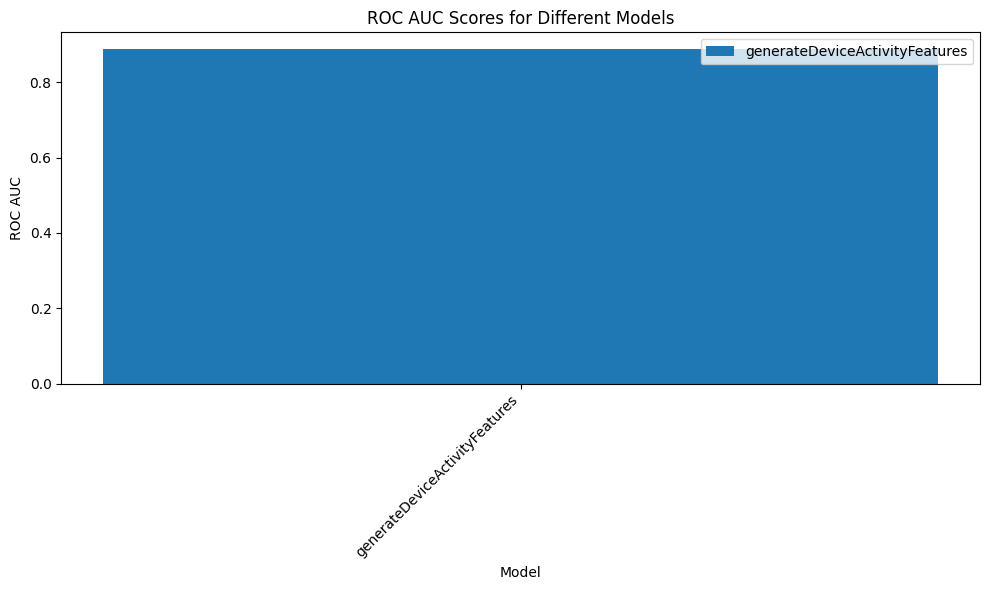

In [35]:

# Print all model names and corresponding mean ROC AUC scores
for model_name, roc_auc_score in models:
    print(f'{model_name}: {roc_auc_score}')

# Plot ROC AUC
plt.figure(figsize=(10, 6))
for model_name, roc_auc_score in models:
    plt.bar(model_name, roc_auc_score, label=model_name)

plt.xlabel('Model')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Scores for Different Models')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
